In [1]:
import sys
import os
import warnings
from pathlib import Path
import logging

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from langchain.vectorstores import FAISS
import google.generativeai as genai
from dotenv import load_dotenv

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import random_seed, PREPROCESSED_BLOG_DATASET_PATH, VECTOR_STORE_PATH
from src.text_extraction import *
from src.models_setup import embedding_model, langchain_embedding_model, gemini_2_flash
from src.prompts import prompt_rag, prompt_five_shots, prompt_retry
from src.output_formats import BlogGeneration, BlogClassification
from src.helpers import get_examples
from src.blog_generator import BlogGenerator

if not logging.getLogger().hasHandlers():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Data Processing

In [2]:
# Import data
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH)

# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    blogs.drop(columns=['normalized_engagement_score']), blogs["normalized_engagement_score"],
    test_size=0.4, random_state=random_seed)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    blogs.drop(columns=['engagement_level', 'normalized_engagement_score']), blogs["engagement_level"],
    test_size=0.4, random_state=random_seed)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (30, 11), y: (30,)
Size of test set, X: (20, 11), y: (20,)


In [3]:
valid_blogs = blogs[blogs["engagement_level"].isin(["Good", "Very Good", "Excellent"])].copy()
valid_blogs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 0 to 47
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           28 non-null     int64  
 1   title_blog                   28 non-null     object 
 2   url_blog                     28 non-null     object 
 3   author_blog                  28 non-null     object 
 4   author_followers             28 non-null     int64  
 5   claps                        28 non-null     int64  
 6   comments                     28 non-null     int64  
 7   title_paper                  28 non-null     object 
 8   url_paper                    28 non-null     object 
 9   engagement_score             28 non-null     float64
 10  normalized_engagement_score  28 non-null     float64
 11  blog_full_text               28 non-null     object 
 12  engagement_level             28 non-null     object 
dtypes: float64(2), int64(4), ob

In [4]:
valid_blogs["full_paper"] = valid_blogs["url_paper"].apply(extract_paper_text)

# Vector storage

In [5]:
elements = []
for text, blog_url, author in zip(valid_blogs["full_paper"],
                                                   valid_blogs["url_blog"],
                                                   valid_blogs["author_blog"]):
    embedding = embedding_model.encode(text, clean_up_tokenization_spaces=True)
    metadata = {
        "full_text": text,
        "blog_url": blog_url,
        "author": author
    }
    elements.append((embedding, metadata))

vector_store = FAISS.from_texts(
    texts=[element[1]["full_text"] for element in elements],
    embedding=langchain_embedding_model,
    metadatas=[element[1] for element in elements]
)

vector_store.save_local(VECTOR_STORE_PATH)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-07 11:43:09,112 - INFO - Loading faiss with AVX2 support.
2025-04-07 11:43:09,150 - INFO - Successfully loaded faiss with AVX2 support.
2025-04-07 11:43:09,159 - INFO - Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes.


In [6]:
vector_store = FAISS.load_local(VECTOR_STORE_PATH,
                                embeddings=langchain_embedding_model,
                                allow_dangerous_deserialization=True)

def find_most_similar_article(query_text):
    query_embedding = embedding_model.encode(query_text, clean_up_tokenization_spaces=True)
    results = vector_store.similarity_search_by_vector(query_embedding, k=2)

    if results:
        most_similar = results[1]
        return most_similar.metadata

# Generator manual test

In [10]:
paper_text = extract_paper_text(blogs.loc[0, "url_paper"])
most_similar_article = find_most_similar_article(paper_text)
example_blog = extract_blog_text(url_blog=most_similar_article["blog_url"],
                                 author_blog=most_similar_article["author"])

# RAG approach
llm_generator = gemini_2_flash.with_structured_output(BlogGeneration, include_raw=True)
generation_chain = prompt_rag | llm_generator
generator_response = generation_chain.invoke({"paper_text": paper_text,
                                              "example_paper": most_similar_article["full_text"],
                                              "example_blog": example_blog})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
print(generator_response["parsed"].text)

# Unlocking the Secrets of Large Language Models: A Beginner's Guide

Have you ever wondered how AI can generate human-like text, translate languages, or even write code? The answer lies in Large Language Models (LLMs), a revolutionary technology that's transforming the world of artificial intelligence.

## From Natural Language Processing to Revolutionary AI

LLMs evolved from natural language processing (NLP), a field focused on enabling computers to understand and process human language. The core insight is that by training on massive amounts of text, these models can acquire knowledge about the world and language, creating a versatile tool for diverse problems.

## The Pre-training Paradigm: Laying the Foundation

Traditional NLP involved training specialized systems from scratch using labeled data. However, LLMs introduce a new paradigm: large-scale pre-training. This involves training a "foundation model" on vast amounts of unlabeled data, which can then be fine-tuned, aligned, a

In [12]:
examples = get_examples()
blog_text = generator_response["parsed"].text

llm_evaluator = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)
evaluation_chain = prompt_five_shots | llm_evaluator
evaluator_response = evaluation_chain.invoke({**examples, "blog_text": blog_text})

In [13]:
print(f"Overall assessment: {evaluator_response["parsed"].overall_assessment}")

Overall assessment: Average


In [14]:
improvements = evaluator_response["parsed"].improvements
print(f"Possible improvements:")
for i, improvement in enumerate(improvements):
    print(f"{i+1}. {improvement}")

Possible improvements:
1. Incorporate more specific examples of LLM applications.
2. Add a section discussing the limitations and potential risks of LLMs.
3. Include a case study or a real-world example of LLM implementation.
4. Provide more technical details about the Transformer architecture.
5. Offer a comparative analysis of different LLM models (e.g., GPT-3 vs. BERT).


In [15]:
possible_improvements = "\n".join([f"{i+1}. {improvement}" for i, improvement in enumerate(improvements)])

# Reflexion
generation_chain = prompt_retry | llm_generator
generator_response = generation_chain.invoke({"generated_blog": blog_text,
                                              "possible_improvements": possible_improvements})

In [16]:
print(generator_response["parsed"].text)

# Unlocking the Secrets of Large Language Models: A Beginner's Guide

Have you ever wondered how AI can generate human-like text, translate languages, or even write code? The answer lies in Large Language Models (LLMs), a revolutionary technology that's transforming the world of artificial intelligence. LLMs are not just theoretical marvels; they're actively used in creating engaging content, powering chatbots, and even assisting in medical diagnoses.

## From Natural Language Processing to Revolutionary AI

LLMs evolved from natural language processing (NLP), a field focused on enabling computers to understand and process human language. The core insight is that by training on massive amounts of text, these models can acquire knowledge about the world and language, creating a versatile tool for diverse problems.

## The Pre-training Paradigm: Laying the Foundation

Traditional NLP involved training specialized systems from scratch using labeled data. However, LLMs introduce a new para

In [17]:
blog_text = generator_response["parsed"].text
evaluator_response = evaluation_chain.invoke({**examples, "blog_text": blog_text})

In [18]:
print(f"Overall assessment: {evaluator_response["parsed"].overall_assessment}")

Overall assessment: Good


# End-to-end generation test

In [19]:
generator = BlogGenerator()

2025-04-06 19:33:29,486 - INFO - Loading vector store...
2025-04-06 19:33:29,491 - INFO - Vector store loaded successfully.
2025-04-06 19:33:29,492 - INFO - BlogGenerator initialized with vector store.


In [20]:
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH)

In [21]:
blog = generator.generate_blog(blogs.loc[0, "url_paper"])

2025-04-06 19:33:29,954 - INFO - Extracting paper text from URL: https://arxiv.org/pdf/2501.09223
2025-04-06 19:33:30,905 - INFO - Attempt number 1: Generating blog...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-06 19:33:31,514 - INFO - Found most similar article.
2025-04-06 19:33:39,325 - INFO - Checking request limits before invoking the model...
2025-04-06 19:33:39,325 - INFO - Invoking the model...
2025-04-06 19:33:45,595 - INFO - Model invoked successfully. Total requests today: 1, RPM: 1, TPM: 184130
2025-04-06 19:33:45,596 - INFO - Blog generated successfully.
2025-04-06 19:33:45,598 - INFO - Checking request limits before invoking the model...
2025-04-06 19:33:45,599 - INFO - Invoking the model...
2025-04-06 19:33:48,039 - INFO - Model invoked successfully. Total requests today: 2, RPM: 2, TPM: 196116
2025-04-06 19:33:48,040 - INFO - Blog evaluated successfully. Evaluation: Average.
2025-04-06 19:33:48,042 - INFO - Blog generation attempt 1 unsuccessful. Retrying...
2025-04-06 19:33:48,044 - INFO - Attempt number 2: Generating blog...
2025-04-06 19:33:48,045 - INFO - Checking request limits before invoking the model...
2025-04-06 19:33:48,047 - INFO - Invoking the model...
2025

In [22]:
print(blog)

## A Practical Guide to Understanding and Applying Large Language Models

TDS Archive

My team and I are excited to share a practical guide that dives into the foundations of Large Language Models (LLMs). As AI continues to revolutionize various fields, understanding the core concepts behind LLMs is becoming increasingly crucial for researchers, developers, and enthusiasts alike. This guide offers a blend of theoretical knowledge and practical applications to help you grasp the power and potential of LLMs.

This blog post is designed to outline the basic concepts of LLMs and introduce related techniques. It focuses on the foundational aspects, providing a clear and accessible overview of how these models work. We'll also explore real-world applications and discuss some of the challenges and ethical considerations surrounding their use.

## What are Large Language Models?

Large Language Models represent a significant leap in artificial intelligence, originating from natural language pr

# Experiments

In [7]:
generator = BlogGenerator(max_retries=5, experiment=True)

2025-04-07 11:43:09,310 - INFO - Loading vector store...
2025-04-07 11:43:09,315 - INFO - Vector store loaded successfully.
2025-04-07 11:43:09,316 - INFO - BlogGenerator initialized with vector store.


In [ ]:
assessment_history = []
best_assessment_history = []
for index, row in Xval.iterrows():
    assessment, best_assessment = generator.generate_blog(row["url_paper"])
    assessment_history.append(assessment)
    best_assessment_history.append(best_assessment)

In [9]:
assessment_history = np.array(assessment_history)
average_assessment = np.mean(assessment_history, axis=0)

best_assessment_history = np.array(best_assessment_history)
average_best_assessment = np.mean(best_assessment_history, axis=0)

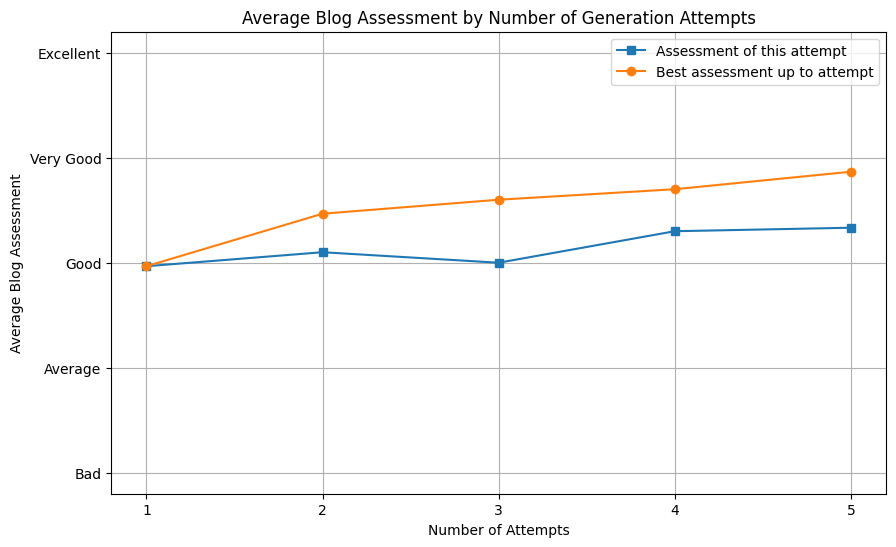

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), average_assessment, marker="s", label="Assessment of this attempt")
plt.plot(range(1, 6), average_best_assessment, marker="o", label="Best assessment up to attempt")

distance_from_edge = 0.2
plt.ylim(1 - distance_from_edge, 5 + distance_from_edge)
plt.yticks([1, 2, 3, 4, 5], ["Bad", "Average", "Good", "Very Good", "Excellent"])
plt.xticks(range(1, 6))

plt.xlabel("Number of Attempts")
plt.ylabel("Average Blog Assessment")
plt.title("Average Blog Assessment by Number of Generation Attempts")
plt.legend()
plt.grid(True)

plt.show()